<a href="https://colab.research.google.com/github/drSigPro/CNN-Classifier-Analysis/blob/main/model_explainability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Explain the trained models through feature visualization (visualize the filters, outputs, activation and understand Grad-CAM, Saliency Map etc)

The Colab notebook is loading a pre-trained and fine-tuned model for bird classification. It then evaluates its performance, and uses visualization techniques like Grad-CAM and saliency maps to understand how the model is making its predictions.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import time
import cv2

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The below two lines of code allow your Colab notebook to access files stored in your Google Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# We will be using the birds dataset with 200 classes of birds from Caltech: https://www.vision.caltech.edu/datasets/cub_200_2011/

**Warning: Images in this dataset overlap with images in ImageNet. **

**Skip the downloading and uploading step in case you have completed part 2 as your dataset will be already in your Gdrive. But remember to update the path below **

Make sure you download the dataset (zip file which already split into train-test dataset) from the [link](https://drive.google.com/file/d/1pt1BcNDcJsEp7QLJgPqGLkuVXy5GeUPw/view?usp=sharing) and upload to a folder in your Gdrive. Once you upload, update the path to the zip file in the below code at "zip_path"

In [ ]:
# Path to your compressed file in Google Drive
zip_path = '/content/drive/MyDrive/AAI3001/Datasets/CUB_200_2011_Split.zip' #Make sure the path to your drive folder is updated!
ROOT = '/content'
datasets.utils.extract_archive(zip_path, ROOT)

'/content'

Split and copy the unzipped dataset into train and test dataset (This will be creating temporary folders in your files [expand folder on left panel and see])

In [ ]:
pretrained_size = 224
pretrained_means = [0.485, 0.456, 0.406]
pretrained_stds= [0.229, 0.224, 0.225]

test_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.CenterCrop(pretrained_size),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means,
                                                std = pretrained_stds)
                       ])

Locate the test dataset from the created folders

In [ ]:
test_dir = '/content/CUB_200_2011_Split/test'
test_data = datasets.ImageFolder(root = test_dir,
                                 transform = test_transforms)

print(f'Number of testing examples: {len(test_data)}')

Number of testing examples: 2374


Define the iterator for iterating through the dataset

In [ ]:
BATCH_SIZE = 64
test_iterator = data.DataLoader(test_data, shuffle = True,
                                batch_size = BATCH_SIZE)

Extract the class names and ignore the numbers

In [ ]:
def format_label(label):
    label = label.split('.')[-1].replace('_', ' ').title().replace(' ', '')
    return label

classes = [format_label(c) for c in test_data.classes]

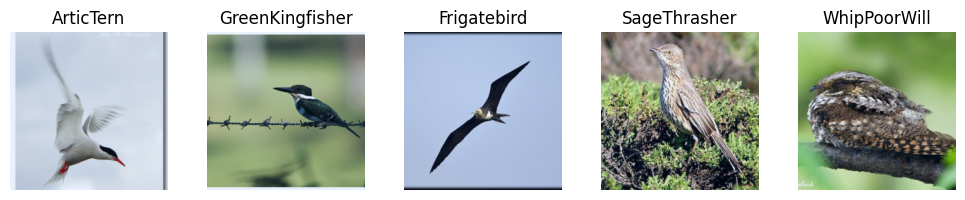

In [ ]:
N = 5 #To select 5 random images to display

# Get one batch from the test_iterator
data_iter = iter(test_iterator)
images, labels = next(data_iter)  # Fetch one batch using next()

# Randomly select N samples from the batch
random_indices = random.sample(range(BATCH_SIZE), N)
random_images = images[random_indices]
random_labels = labels[random_indices]

# Plot the random images
fig, axes = plt.subplots(1, N, figsize=(N * 2, 2))
for i in range(N):
    img = random_images[i].permute(1, 2, 0)  # Reorder the tensor for plotting (channels last)
    # Normalize the image data to [0, 1]
    img = (img - img.min()) / (img.max() - img.min())
    axes[i].imshow(img.numpy())  # Convert tensor to numpy for display
    axes[i].set_title(f"{classes[random_labels[i].item()]}")
    axes[i].axis('off')  # Hide axes for cleaner visualization

plt.tight_layout()
plt.show()

In [ ]:
model = models.resnet50(pretrained = True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 203MB/s]


The below code snippet is essentially tailoring the ResNet50 model to work with a new dataset. It does this by:

Finding out how many input features the model's final layer expects.
Determining the desired number of output classes based on the dataset.
Creating a new final layer with the correct input and output dimensions.
Replacing the model's original final layer with the new one.


In [ ]:
IN_FEATURES = model.fc.in_features
OUTPUT_DIM = len(test_data.classes) #Output will be modified for 200 classes instead of the original 1000 classes
fc = nn.Linear(IN_FEATURES, OUTPUT_DIM)
model.fc = fc

Load the weights which we have trained in Part 2. You should ideally use your own trained weights. But in case the weights are not available/training was facing an error, you can download the weights from the [link](https://drive.google.com/file/d/13Y412jFzsh1UjuBxB3oi8iy5BIMq-6HS/view?usp=sharing). Upload the weights back to your Gdrive and update the path below accoringly.

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/AAI3001/Week8/ResNet50_birds_model.pt'))

<ipython-input-12-b6b8a41c5810>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/AAI3001/Week8/ResNet50_birds_model.

<All keys matched successfully>

In [ ]:
model = model.to(device)

The below function assesses how often the correct label is within the top k predictions made by the model, providing a measure of its performance. Historically, for the ImageNet challenge the models are evaluated for top 1% and 5% accuracy.

Top-k Accuracy = (Number of Correct Top-k Predictions) / (Total Number of Predictions)

Where:

Number of Correct Top-k Predictions: This is the count of instances where the true label is among the top k predictions made by the model for a given sample.
Total Number of Predictions: This is simply the total number of samples being evaluated.

In [ ]:
def calculate_topk_accuracy(y_pred, y, k = 5):
    with torch.no_grad():
        batch_size = y.shape[0]
        _, top_pred = y_pred.topk(k, 1)
        top_pred = top_pred.t()
        correct = top_pred.eq(y.view(1, -1).expand_as(top_pred))
        correct_1 = correct[:1].reshape(-1).float().sum(0, keepdim = True)
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim = True)
        acc_1 = correct_1 / batch_size
        acc_k = correct_k / batch_size
    return acc_1, acc_k

The evaluate function (below) employs the top 1% and k% accuracy

In [ ]:
def evaluate(model, iterator, device):

    epoch_acc_1 = 0
    epoch_acc_5 = 0
    images = []
    labels = []
    probs = []
    outputs = []

    model.eval()

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)


            # Calculate top 1% and k% accuracy
            acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)
            epoch_acc_1 += acc_1.item()
            epoch_acc_5 += acc_5.item()

            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())
            outputs.append(y_pred.cpu())



    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)
    outputs = torch.cat(outputs, dim = 0)

    return epoch_acc_1, epoch_acc_5, images, labels, probs, outputs

Now we will load the trained weights stored in the drive and test the model for top 1% and 5% accuracy

In [ ]:
test_acc_1, test_acc_5, images, labels, probs, outputs = evaluate(model, test_iterator, device)
pred_labels = torch.argmax(probs, 1)

print(f'Test Acc @1: {test_acc_1*100:6.2f}% | ' \
      f'Test Acc @5: {test_acc_5*100:6.2f}%')

Test Acc @1:  75.95% | Test Acc @5:  93.76%


# Lets test the Gradient-weighted Class Activation Mapping (Grad-CAM) to observe where the network is looking at while making a prediction

Identify a layer which you want to observe (can use print(model) forthe same). In the below example, we have used model.layer4[2].conv3 which is the final convolutional layer in ResNet50

In [ ]:
# Grad-CAM Implementation
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None

        # Register hook to capture gradients
        target_layer.register_backward_hook(self.save_gradient)

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def __call__(self, x):
        feature_map = None

        def forward_hook(module, input, output):
            nonlocal feature_map
            feature_map = output

        hook = self.target_layer.register_forward_hook(forward_hook)
        output = self.model(x)
        hook.remove()

        # Backpropagate to get gradients
        # Iterate over batch to process each image separately
        for i in range(output.shape[0]):
            class_idx = torch.argmax(output[i], dim=0).item() # Get predicted class for the current image
            self.model.zero_grad()
            output[i, class_idx].backward(retain_graph=True) # Backpropagate for the current image

        # Calculate Grad-CAM
        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])
        feature_map = feature_map[0]

        # Apply Grad-CAM
        for i in range(len(pooled_gradients)):
            feature_map[i, :, :] *= pooled_gradients[i]

        heatmap = torch.mean(feature_map, dim=0).cpu().detach().numpy()
        heatmap = np.maximum(heatmap, 0)
        if np.max(heatmap) != 0:
            heatmap /= np.max(heatmap)

        # Resize heatmap and superimpose on the original image
        heatmap = cv2.resize(heatmap, (x.shape[3], x.shape[2]))
        heatmap = np.uint8(255 * heatmap)
        heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

        # Detach the tensor from the computation graph before converting to NumPy
        img = x[0].detach().permute(1, 2, 0).cpu().numpy().clip(0, 1)
        img = np.uint8(255 * img)

        superimposed_img = cv2.addWeighted(heatmap, 0.3, img, 0.7, 0)

        # Plot original image, Grad-CAM heatmap, and superimposed image side by side
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))

        # Original Image
        ax[0].imshow(img)
        ax[0].set_title("Original Image")
        ax[0].axis('off')

        # Grad-CAM Heatmap
        ax[1].imshow(heatmap)
        ax[1].set_title("Grad-CAM Heatmap")
        ax[1].axis('off')

        # Superimposed Image
        ax[2].imshow(superimposed_img)
        ax[2].set_title("Grad-CAM Superimposed")
        ax[2].axis('off')

        plt.tight_layout()
        plt.show()

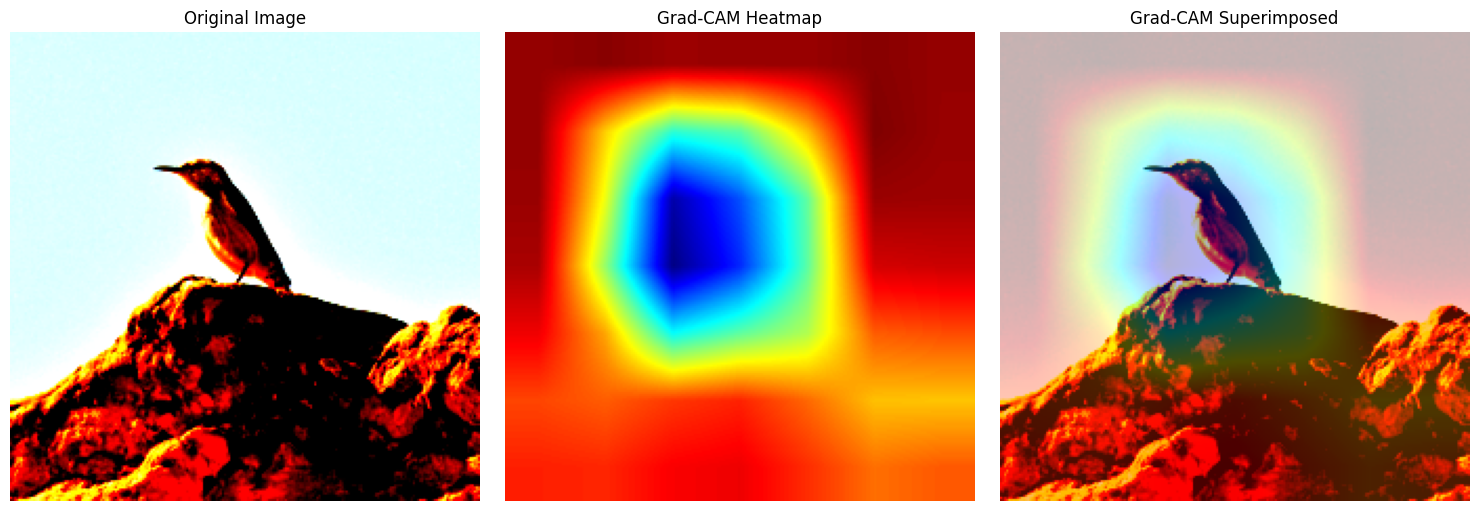

In [ ]:
# Using GradCAM. You can change the image number and observe for various images
img_idx =100
gradcam = GradCAM(model, model.layer4[2].conv3)
gradcam(images[img_idx].unsqueeze(0).to(device))

# Use Saliency map to observe the most important gradient changes (spatially).

In [ ]:
images_subset = images[:5]
labels_subset = labels[:5]

images_subset.requires_grad = True
model.eval()
model.to("cpu")
outputs = model(images_subset)
score, predicted_class = torch.max(outputs, 1) # Note here the score employed is for the class with maximum probability

# Backpropagate to obtain the gradients
model.zero_grad()
total_score = torch.sum(score) # or total_score = torch.mean(score)
total_score.backward()

# Get saliency map
saliency, _ = torch.max(images_subset.grad.data.abs(), dim=1)

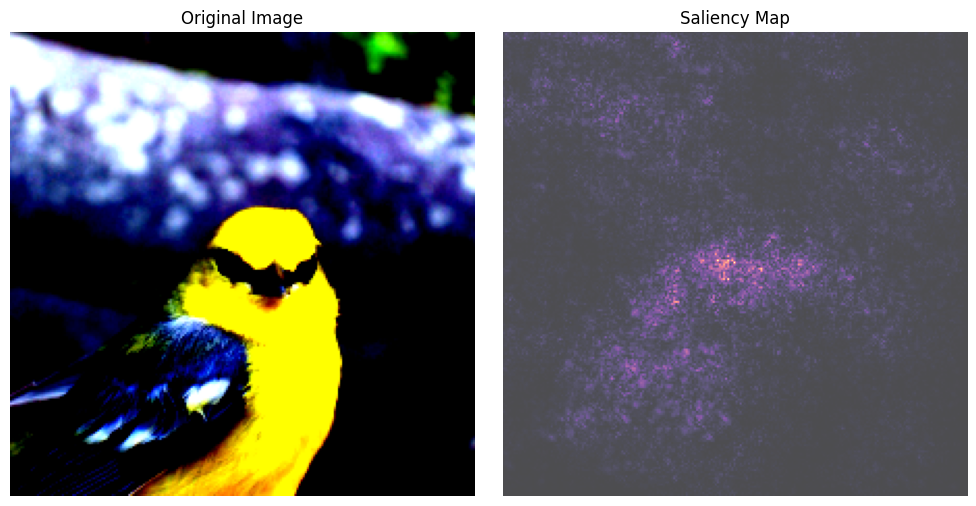

In [ ]:
# Plot original image and saliency map side by side
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Original Image
ax[0].imshow(images_subset[1].permute(1, 2, 0).detach().numpy().clip(0, 1))
ax[0].set_title("Original Image")
ax[0].axis('off')

# Saliency Map
ax[1].imshow(saliency[1].cpu().numpy(), cmap='magma', alpha=0.7)
ax[1].set_title("Saliency Map")
ax[1].axis('off')

plt.tight_layout()
plt.show()


Now we will employ a library to see the CAMs. Please see https://jacobgil.github.io/pytorch-gradcam-book/introduction.html

In [ ]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 52.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.4-py3-none-any.whl size=39589 sha256=6ed9f447307a7d6512b9d5d1c7c87f821edb05398090a886d52ffc10b6bf6b2d
  Stored in directory: /root/.cache/pip/wheels/50/b0/82/1f97b5348c7fe9f0ce0ba18497202cafa5dec4562bd5292680
Successfully built grad-cam


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


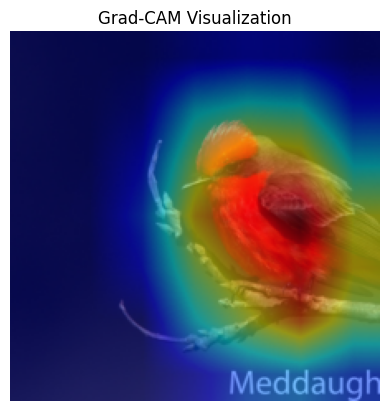

In [ ]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

target_layers = [model.layer4[-1]]

# Note: input_tensor can be a batch tensor with several images!
# input_tensor = images[0:7] # Create an input tensor image for your model..
input_tensor = images_subset

# We have to specify the target we want to generate the CAM for.
#targets = None
# targets = [ClassifierOutputTarget(label) for label in labels[0:7].tolist()]
targets = [ClassifierOutputTarget(label) for label in labels_subset.tolist()]


# Construct the CAM object once, and then re-use it on many images.
with GradCAM(model=model, target_layers=target_layers) as cam:
  # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
  grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
  # In this example grayscale_cam has only one image in the batch:
  grayscale_cam = grayscale_cam[0, :]

  # Convert the image to numpy array and normalize to 0-1 range
  img_np = images_subset[0].cpu().detach().numpy()
  img_np = img_np.transpose((1, 2, 0)) # Change channel order to HWC
  img_np = (img_np - np.min(img_np)) / (np.max(img_np) - np.min(img_np)) # Normalize to 0-1

  visualization = show_cam_on_image(img_np, grayscale_cam, use_rgb=True)
  # You can also get the model outputs without having to redo inference
  model_outputs = cam.outputs

  # Display the visualization using Matplotlib
  plt.imshow(visualization)
  plt.title("Grad-CAM Visualization")
  plt.axis('off')
  plt.show()

# Lets now plot the output of the convolution kernels and display some of them

Again we can use a certain layer weight for the purpose (e.g. in the below example we have used model.conv1.weight.data)

In [ ]:
def plot_filtered_images(images, filters, n_filters = None, normalize = True):

    images = torch.cat([i.unsqueeze(0) for i in images], dim = 0).cpu()
    filters = filters.cpu()

    if n_filters is not None:
        filters = filters[:n_filters]

    n_images = images.shape[0]
    n_filters = filters.shape[0]

    filtered_images = F.conv2d(images, filters)

    fig = plt.figure(figsize = (30, 30))

    for i in range(n_images):

        image = images[i]

        if normalize:
            image = (image - image.min()) / (image.max() - image.min())

        ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters))
        ax.imshow(image.permute(1,2,0).numpy())
        ax.set_title('Original')
        ax.axis('off')

        for j in range(n_filters):
            image = filtered_images[i][j]

            if normalize:
                image = (image - image.min()) / (image.max() - image.min())

            ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters)+j+1)
            ax.imshow(image.numpy(), cmap = 'bone')
            ax.set_title(f'Filter {j+1}')
            ax.axis('off');

    fig.subplots_adjust(hspace = -0.7)

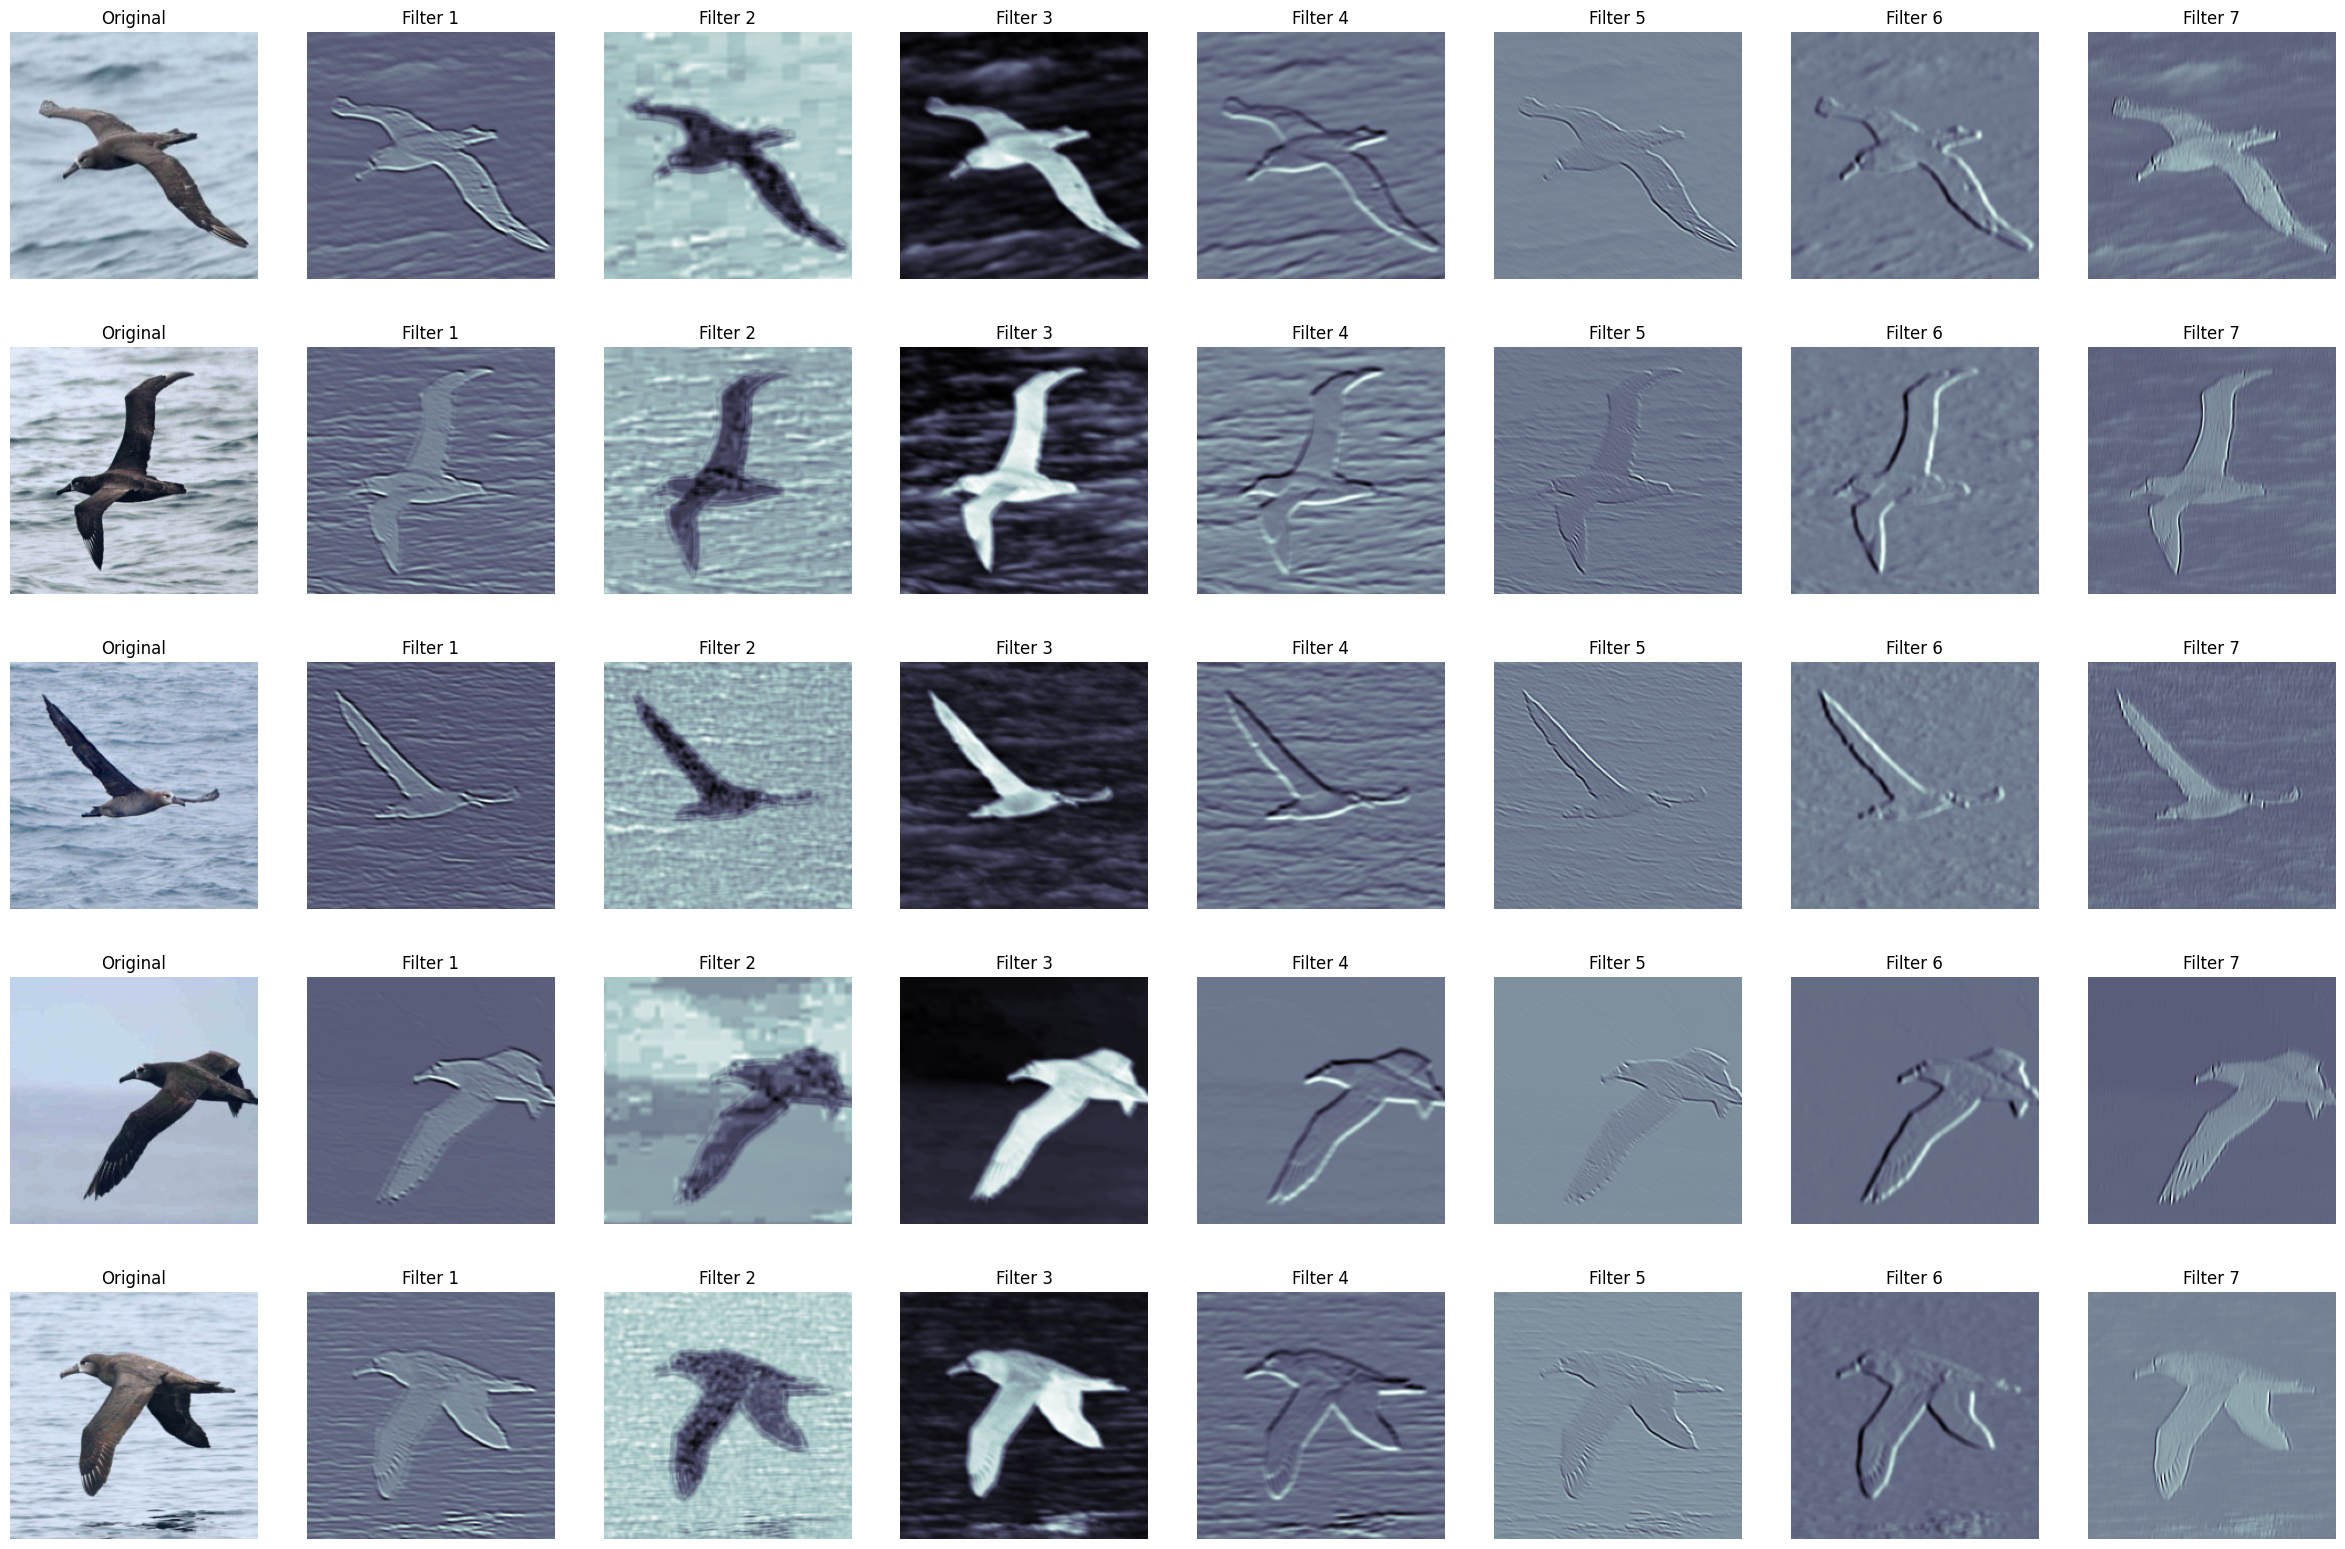

In [ ]:
N_IMAGES = 5
N_FILTERS = 7

images = [image for image, label in [test_data[i] for i in range(N_IMAGES)]]
filters = model.conv1.weight.data

plot_filtered_images(images, filters, N_FILTERS)

In [ ]:
def plot_filters(filters, normalize = True):

    filters = filters.cpu()

    n_filters = filters.shape[0]

    rows = int(np.sqrt(n_filters))
    cols = int(np.sqrt(n_filters))

    fig = plt.figure(figsize = (30, 15))

    for i in range(rows*cols):

        image = filters[i]

        if normalize:
            image = (image - image.min()) / (image.max() - image.min())

        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(image.permute(1, 2, 0))
        ax.axis('off')

    fig.subplots_adjust(wspace = -0.9)

64


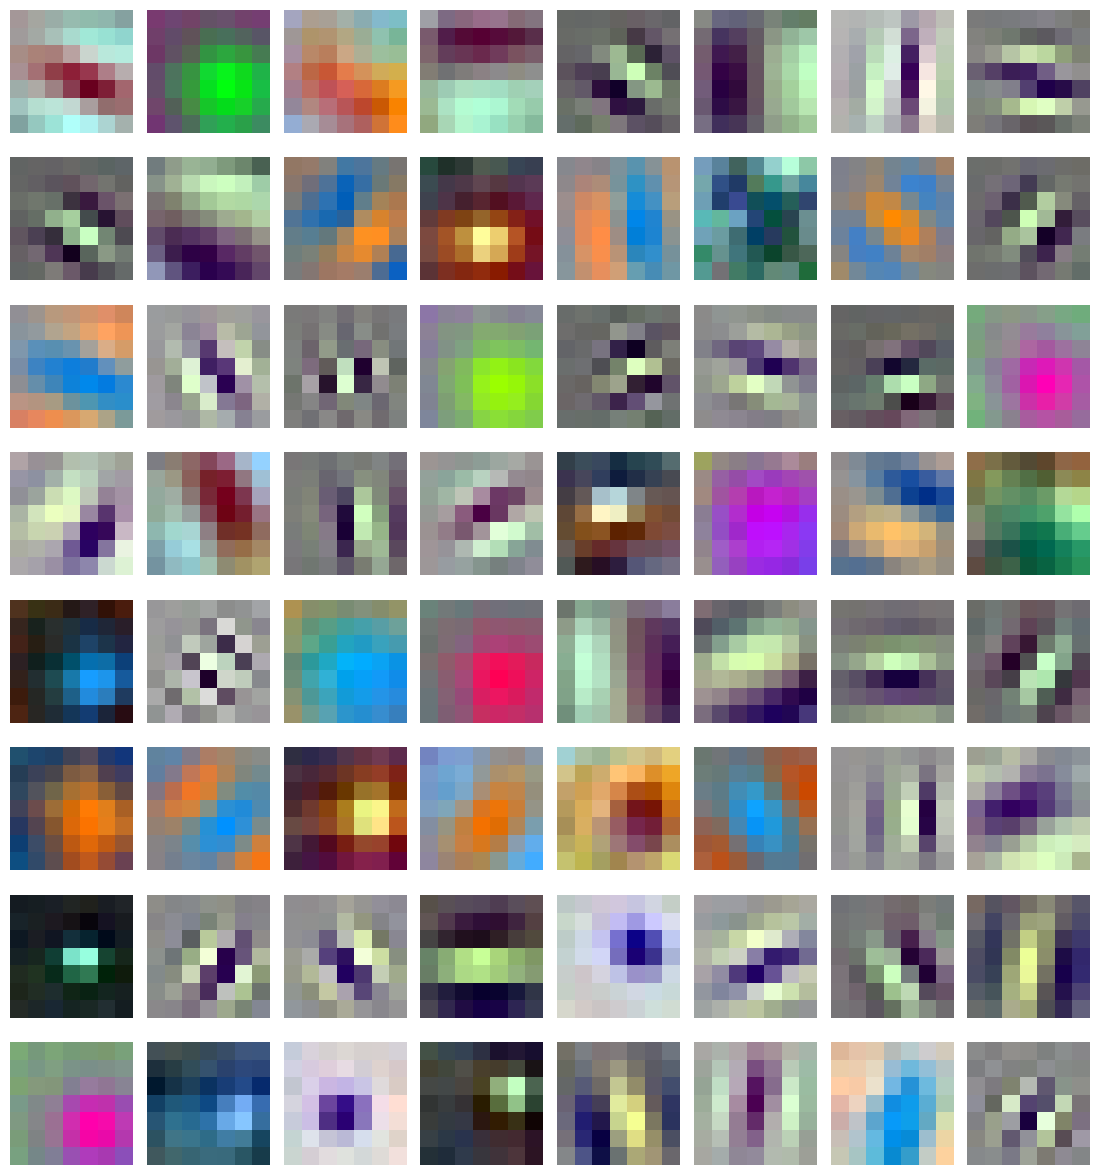

In [ ]:
print(len(filters))
plot_filters(filters)

# To do as home work

1. For the test dataset, now don't initialize the weights with the trained weights, but keep the original ImageNet weights. Consider any random 10 images from the test dataset and analyze the predictions through GRAD-CAM and Saliency Map for both ImageNet weights and retrained weights. Report your inference also.